<a href="https://colab.research.google.com/github/AnshuMishra01/LLM-Scratch/blob/main/Transformer_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Architecture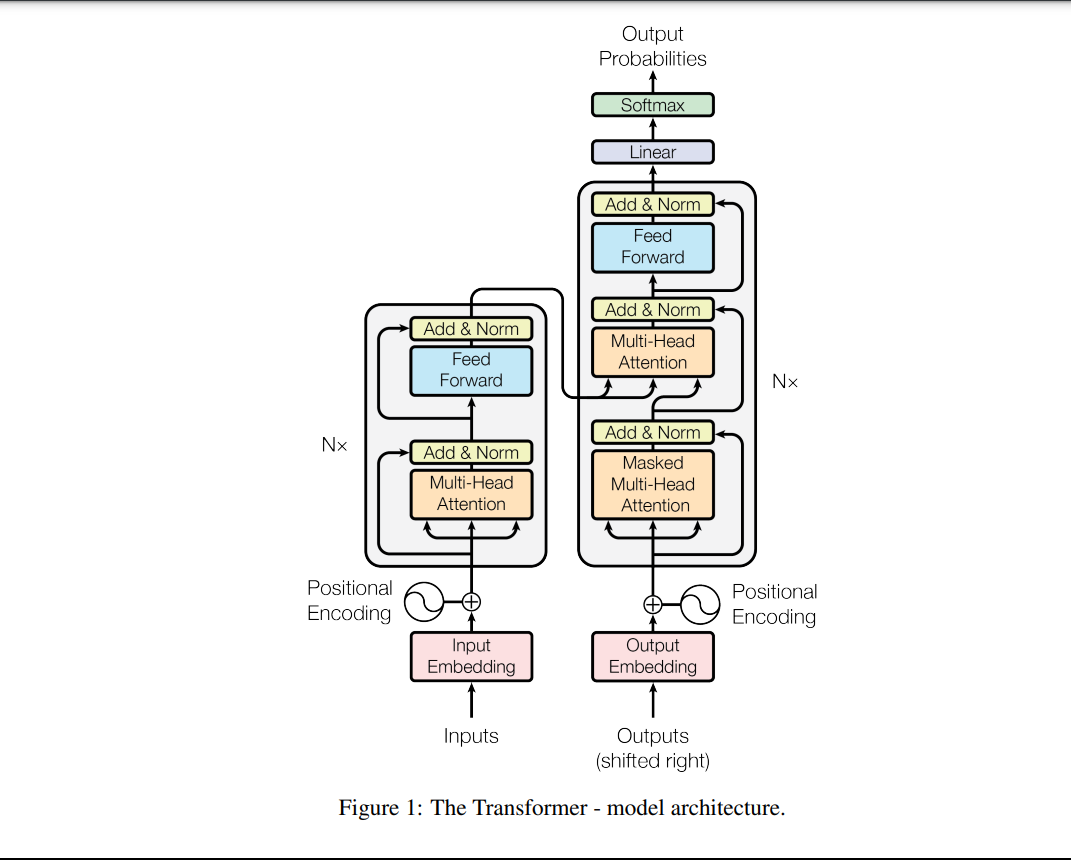

Research Paper -https://arxiv.org/abs/1706.03762

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:
class InputEmbedding(nn.Module):
  def __init__(self, vocab_size : int, d_model: int):
    super.__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.embedding = nn.Embedding(vocab_size, d_model)


  def forward(self, input):
    return self.embedding(input)*math.sqrt(self.d_model)



In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, sequence_length: int, dropout: int) -> None:
    super.__init__()
    self.d_model = d_model
    self.sequence_length = sequence_length
    self.dropout = nn.Dropout(dropout)
    pos_en = torch.zeros(sequence_length, d_model)

    #Numerator
    position = torch.arrange(0, sequence_length, dtype = torch.float).unsqueeze(1)
    #Denominator
    den = torch.exp(torch.arrange(0, d_model,2).float()*(-math.log(10000,0)/d_model))
    #Even Positions
    pos_en[:,0::2] = torch.sin(position*den)
    #Odd Positions
    pos_en[:,1::2] = torch.cos(position*den)

    pos_en = pos_en.unsqueeze(0)
    self.register_buffer('pos_en',pos_en)

  def forward(self, input):
    input = input + (self.pos_en[:,:input.shape[1], :]).requires_grad_(False)
    return self.dropout(input)

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, eps: float = 10**6) -> None:
    super.__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones[1])
    self.bias = nn.Parameter(torch.zeros[1])

  def forward(self, input):
    mean = input.mean(dim =-1, keepdim = True)
    std = input.std(dim =-1, keepdim = True)
    return self.alpha* (input - mean)/(std + self.eps) + self.bias

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,d_model: int, d_ff : int, dropout: float) -> None:
    super.__init__()
    self.d_model = d_model
    self.d_ff = d_ff
    self.dropout = nn.Dropout(dropout)
    self.linear_1 = nn.Linear(d_model,d_ff)
    self.linear_2 = nn.Linear(d_ff, d_model)

  def forward(self, input):
    return self.linear_2(self.dropout(torch.relu(self.linear_1(input))))

In [ ]:
def MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int, dropout: float, h:int) -> None:
    super.__init()
    self.d_model = d_model
    self.h = h
    self.dropout = nn.Dropout(dropout)

    assert  d_model % h ==0 , "D_model IS NOT DIVISIBLE BY H"
    self.d_k = d_model //
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)

  @staticmethod
  def attention(query, key, value, mask, dropout : nn.Dropout):
    d_k = key[-1]
    attention_scores = (query @ key.transpose(-2,-1))/math.sqrt(d_k)
    if mask is not None:
      attention_scores.masked_fill_(mask==0, -1e9)
    attention_scores = attention_scores.softmax(dim =-1)
    if dropout is not None:
      attention_scores = dropout(attention_scores)
    return (attention_scores @ value), attention_scores


  def forward(self, k,q,v, mask):
    query = w_q(q)
    key = w_k(k)
    value = w_v(v)
    query = query.view(query.shape[0],query.shape[1],self.h, self.d_k).transpose(1,2)
    key = key.view(key.shape[0]), key.shape[1], self.h, self.d_k).transpose(1,2)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(!,2)
    x, self.attention_scores = MultiHeadAttention.attention(query, key, value, maks, dropout)
    x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.h*self.d_k)
    return self.w_o(x)

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self, dropout: float) => None:
    super.__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()
  def forward(self,x, sublayer):
    return x+ self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderBlock():
    def __init__(self, features: int, self_attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])
    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [ ]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttention, cross_attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        return self.proj(x)

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        return self.projection_layer(x)

In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    src_embed = InputEmbedding(d_model, src_vocab_size)
    tgt_embed = InputEmbedding(d_model, tgt_vocab_size)

    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForward(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForward(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer